In [2]:
# All Imports

from numba import jit
from numba import njit, prange

from odl.ufunc_ops.ufunc_ops import log_op
from dival.evaluation import TaskTable
from dival.measure import PSNR, SSIM
from dival.reconstructors.odl_reconstructors import FBPReconstructor
from dival.datasets.standard import get_standard_dataset
from dival.util.constants import MU_MAX
#from odl.util import phantom
import numpy as np
import odl

import matplotlib.pyplot as plt




In [3]:
# Other Functions

@jit(nopython=True, parallel=True)
def my_divide(x, y):
    return np.divide(x, y)

@jit(nopython=True, parallel=True)
def my_add(x, y):
    return np.add(x, y)

@jit(nopython=True, parallel=True)
def my_mul(x, y):
    return np.multiply(x, y)

@njit(parallel=True)
def G_Huber_prior_sart(estbuf, delta):
    priorbuf = np.zeros(estbuf.shape)
    cent     = 1
    
    for ind_x in prange(3, estbuf.shape[0]-3):
        for ind_y in prange(3, estbuf.shape[1]-3):
                for ind_nr_y in range(ind_y-1, ind_y+2):
                    for ind_nr_x in range(ind_x-1, ind_x+2):
                        distance = np.sqrt(float((ind_nr_x-ind_x)*(ind_nr_x-ind_x)+(ind_nr_y-ind_y)*(ind_nr_y-ind_y)))

                        if (distance == 0.0):
                            distance = 1.0
                        
                        diff        = estbuf[ind_x][ind_y] - estbuf[ind_nr_x][ind_nr_y]
                        denominator = np.sqrt(1.0+(diff/delta)*(diff/delta))
                        priorbuf[ind_x][ind_y] = priorbuf[ind_x][ind_y] + diff
                        #priorbuf[ind_x][ind_y] = priorbuf[ind_x][ind_y] + (1.0/distance)*diff/denominator
    return priorbuf

In [4]:
dataset    = get_standard_dataset('lodopab', observation_model='post-log', min_photon_count=0.5)
ray_trafo  = dataset.get_ray_trafo(impl='astra_cuda')
reco_space = ray_trafo.domain

In [5]:
print(ray_trafo)

RayTransform


In [11]:
# Recon Loop

dataset    = get_standard_dataset('lodopab', observation_model='post-log', min_photon_count=0.5)
ray_trafo  = dataset.get_ray_trafo(impl='astra_cuda')
reco_space = ray_trafo.domain
#test_data  = dataset.get_data_pairs('test', 5)


niter = 200

# quadratic: 0 to 0.01

for i in range(2000):
    temp1        = dataset.get_samples(range(i, i+2))
    #print(i, temp1[0].shape)
    
    proj_arr     = np.array(temp1[0][0])
    delta        = 0.0002
    
    beta_array = [0]
    np.random.seed(int(i)*15)
    #random.seed(int(i)*15)
    
    for k in range(4):
        beta_array.append(np.random.uniform(0.001, 0.01))
    beta_array       = np.around(beta_array, decimals=5)
    
    all_vols = np.zeros([5, 362, 362])
    
    print('Reconstructing ', i)
    for pk, beta in enumerate(beta_array):
        print('beta ', beta)
        
        vol_rec      = np.zeros([362, 362])
        only_ones_v  = np.ones(vol_rec.shape)
        only_ones_p  = np.ones(proj_arr.shape)
        
        temp_C    = ray_trafo.adjoint(only_ones_p)
        temp_R    = np.array(ray_trafo(only_ones_v))
        
        for j in range(0, niter):
            #print("Iteration ", j)

            prior     = G_Huber_prior_sart(vol_rec, delta)

            p         = np.array(ray_trafo(vol_rec))
            diff      = proj_arr - p

            cost = np.square(diff)
            #print("Cost is ", np.sum(cost), prior.shape, vol_rec.shape)

            diff      = np.divide(diff, temp_R)
            temp_back = ray_trafo.adjoint(diff)

            vol       = np.divide(temp_back, temp_C)
            vol       = np.nan_to_num(vol)

            vol      = np.reshape(vol, vol_rec.shape)
            vol_rec  = vol_rec + 0.9*(vol- beta*prior)
            vol_rec[vol_rec < 0] = 0
        
        all_vols[pk] = vol_rec
        np.save('/media/yu-hao/WindowsData/DivalRecon/'+str(i)+'_img_quadratic1.npy',  all_vols)
        np.save('/media/yu-hao/WindowsData/DivalRecon/'+str(i)+'_beta_quadratic1.npy', beta_array)

Reconstructing  0
beta  0.0


<ipython-input-11-af413fcc1caa>:52: RuntimeWarning: divide by zero encountered in true_divide
  diff      = np.divide(diff, temp_R)
<ipython-input-11-af413fcc1caa>:52: RuntimeWarning: invalid value encountered in true_divide
  diff      = np.divide(diff, temp_R)


beta  0.00594
beta  0.00744
beta  0.00642
beta  0.0059
Reconstructing  1
beta  0.0
beta  0.00864
beta  0.00261
beta  0.00149
beta  0.00425
Reconstructing  2
beta  0.0
beta  0.0068
beta  0.00443
beta  0.00697
beta  0.00247
Reconstructing  3
beta  0.0
beta  0.0099
beta  0.00595
beta  0.00353
beta  0.0017
Reconstructing  4
beta  0.0
beta  0.00371
beta  0.00268
beta  0.00391
beta  0.00699
Reconstructing  5
beta  0.0
beta  0.00612
beta  0.00159
beta  0.00899
beta  0.00937
Reconstructing  6
beta  0.0
beta  0.00238
beta  0.00242
beta  0.00987
beta  0.00914
Reconstructing  7
beta  0.0
beta  0.00175
beta  0.004
beta  0.00873
beta  0.00195
Reconstructing  8
beta  0.0
beta  0.0071
beta  0.00562
beta  0.00661
beta  0.00529
Reconstructing  9
beta  0.0
beta  0.00695
beta  0.00395
beta  0.00276
beta  0.00877
Reconstructing  10
beta  0.0
beta  0.00918
beta  0.00332
beta  0.0089
beta  0.00765
Reconstructing  11
beta  0.0
beta  0.00844
beta  0.00654
beta  0.00919
beta  0.00975
Reconstructing  12
beta  0

beta  0.00204
beta  0.00873
beta  0.00729
Reconstructing  98
beta  0.0
beta  0.00987
beta  0.00964
beta  0.00905
beta  0.0098
Reconstructing  99
beta  0.0
beta  0.00301
beta  0.00325
beta  0.00487
beta  0.00257
Reconstructing  100
beta  0.0
beta  0.00986
beta  0.0019
beta  0.00742
beta  0.00229
Reconstructing  101
beta  0.0
beta  0.00972
beta  0.00724
beta  0.00761
beta  0.00556
Reconstructing  102
beta  0.0
beta  0.00331
beta  0.0011
beta  0.00507
beta  0.00567
Reconstructing  103
beta  0.0
beta  0.00643
beta  0.00674
beta  0.00203
beta  0.00752
Reconstructing  104
beta  0.0
beta  0.00697
beta  0.00965
beta  0.00207
beta  0.00459
Reconstructing  105
beta  0.0
beta  0.00727
beta  0.00864
beta  0.00556
beta  0.00977
Reconstructing  106
beta  0.0
beta  0.00112
beta  0.00649
beta  0.00693
beta  0.00312
Reconstructing  107
beta  0.0
beta  0.00829
beta  0.00145
beta  0.00893
beta  0.00797
Reconstructing  108
beta  0.0
beta  0.00635
beta  0.00811
beta  0.00814
beta  0.00644
Reconstructing  1

beta  0.0052
beta  0.00265
beta  0.00112
beta  0.00295
Reconstructing  194
beta  0.0
beta  0.00758
beta  0.00225
beta  0.0093
beta  0.00491
Reconstructing  195
beta  0.0
beta  0.00375
beta  0.00564
beta  0.00434
beta  0.00405
Reconstructing  196
beta  0.0
beta  0.00491
beta  0.00958
beta  0.00585
beta  0.00762
Reconstructing  197
beta  0.0
beta  0.00673
beta  0.00413
beta  0.00703
beta  0.00391
Reconstructing  198
beta  0.0
beta  0.00261
beta  0.0089
beta  0.00169
beta  0.00676
Reconstructing  199
beta  0.0
beta  0.00188
beta  0.00931
beta  0.00328
beta  0.00334
Reconstructing  200
beta  0.0
beta  0.0056
beta  0.00627
beta  0.0074
beta  0.00393
Reconstructing  201
beta  0.0
beta  0.00919
beta  0.00751
beta  0.00797
beta  0.00627
Reconstructing  202
beta  0.0
beta  0.00451
beta  0.00114
beta  0.00977
beta  0.00989
Reconstructing  203
beta  0.0
beta  0.00399
beta  0.00725
beta  0.00917
beta  0.00181
Reconstructing  204
beta  0.0
beta  0.00557
beta  0.00134
beta  0.00759
beta  0.00512
Rec

beta  0.00781
beta  0.00458
beta  0.00188
beta  0.00374
Reconstructing  290
beta  0.0
beta  0.00111
beta  0.00431
beta  0.00571
beta  0.00197
Reconstructing  291
beta  0.0
beta  0.00469
beta  0.00811
beta  0.0056
beta  0.00477
Reconstructing  292
beta  0.0
beta  0.00717
beta  0.00789
beta  0.00267
beta  0.00551
Reconstructing  293
beta  0.0
beta  0.0082
beta  0.00828
beta  0.00223
beta  0.00485
Reconstructing  294
beta  0.0
beta  0.00344
beta  0.00858
beta  0.00125
beta  0.00436
Reconstructing  295
beta  0.0
beta  0.00663
beta  0.00185
beta  0.00338
beta  0.00892
Reconstructing  296
beta  0.0
beta  0.00868
beta  0.00988
beta  0.0017
beta  0.00609
Reconstructing  297
beta  0.0
beta  0.00194
beta  0.00995
beta  0.00395
beta  0.00969
Reconstructing  298
beta  0.0
beta  0.00508
beta  0.00619
beta  0.00388
beta  0.00336
Reconstructing  299
beta  0.0
beta  0.00194
beta  0.00375
beta  0.00391
beta  0.00455
Reconstructing  300
beta  0.0
beta  0.0061
beta  0.00586
beta  0.00989
beta  0.00128
Re

beta  0.00507
beta  0.00837
beta  0.00773
beta  0.00222
Reconstructing  386
beta  0.0
beta  0.00206
beta  0.00678
beta  0.00445
beta  0.00478
Reconstructing  387
beta  0.0
beta  0.00293
beta  0.00202
beta  0.00656
beta  0.00285
Reconstructing  388
beta  0.0
beta  0.0037
beta  0.00571
beta  0.00933
beta  0.00422
Reconstructing  389
beta  0.0
beta  0.00771
beta  0.00346
beta  0.0047
beta  0.00522
Reconstructing  390
beta  0.0
beta  0.00144
beta  0.00443
beta  0.00706
beta  0.00725
Reconstructing  391
beta  0.0
beta  0.00551
beta  0.00188
beta  0.00694
beta  0.00876
Reconstructing  392
beta  0.0
beta  0.00778
beta  0.00406
beta  0.00163
beta  0.0076
Reconstructing  393
beta  0.0
beta  0.00259
beta  0.00965
beta  0.00165
beta  0.00676
Reconstructing  394
beta  0.0
beta  0.00611
beta  0.00893
beta  0.00519
beta  0.00136
Reconstructing  395
beta  0.0
beta  0.00776
beta  0.00988
beta  0.00277
beta  0.0067
Reconstructing  396
beta  0.0
beta  0.00514
beta  0.00736
beta  0.0025
beta  0.00531
Rec

beta  0.00943
beta  0.00218
beta  0.00452
beta  0.00217
Reconstructing  482
beta  0.0
beta  0.00458
beta  0.00745
beta  0.00513
beta  0.0058
Reconstructing  483
beta  0.0
beta  0.00911
beta  0.00721
beta  0.00593
beta  0.00466
Reconstructing  484
beta  0.0
beta  0.00963
beta  0.00548
beta  0.00222
beta  0.00166
Reconstructing  485
beta  0.0
beta  0.00278
beta  0.00953
beta  0.00846
beta  0.00945
Reconstructing  486
beta  0.0
beta  0.00395
beta  0.00722
beta  0.00163
beta  0.00869
Reconstructing  487
beta  0.0
beta  0.00889
beta  0.00444
beta  0.00124
beta  0.00648
Reconstructing  488
beta  0.0
beta  0.00839
beta  0.0014
beta  0.0054
beta  0.002
Reconstructing  489
beta  0.0
beta  0.00559
beta  0.00723
beta  0.00275
beta  0.00141
Reconstructing  490
beta  0.0
beta  0.00171
beta  0.00148
beta  0.00944
beta  0.00758
Reconstructing  491
beta  0.0
beta  0.00632
beta  0.00287
beta  0.00877
beta  0.0059
Reconstructing  492
beta  0.0
beta  0.00507
beta  0.00641
beta  0.00784
beta  0.00461
Reco

beta  0.00735
beta  0.00663
beta  0.00524
beta  0.00297
Reconstructing  578
beta  0.0
beta  0.00362
beta  0.00748
beta  0.0032
beta  0.00725
Reconstructing  579
beta  0.0
beta  0.0079
beta  0.00962
beta  0.00399
beta  0.00398
Reconstructing  580
beta  0.0
beta  0.00179
beta  0.00283
beta  0.00851
beta  0.00871
Reconstructing  581
beta  0.0
beta  0.00375
beta  0.0015
beta  0.00378
beta  0.00332
Reconstructing  582
beta  0.0
beta  0.00278
beta  0.00262
beta  0.00237
beta  0.00864
Reconstructing  583
beta  0.0
beta  0.00197
beta  0.00754
beta  0.00595
beta  0.00732
Reconstructing  584
beta  0.0
beta  0.00433
beta  0.00864
beta  0.00225
beta  0.00963
Reconstructing  585
beta  0.0
beta  0.00228
beta  0.00969
beta  0.00285
beta  0.00783
Reconstructing  586
beta  0.0
beta  0.00733
beta  0.00967
beta  0.00659
beta  0.00332
Reconstructing  587
beta  0.0
beta  0.00991
beta  0.00667
beta  0.00599
beta  0.00678
Reconstructing  588
beta  0.0
beta  0.00388
beta  0.00886
beta  0.00324
beta  0.00484
R

beta  0.00947
beta  0.00789
beta  0.0072
beta  0.00455
Reconstructing  674
beta  0.0
beta  0.00901
beta  0.00858
beta  0.00218
beta  0.00456
Reconstructing  675
beta  0.0
beta  0.00294
beta  0.00286
beta  0.00135
beta  0.00687
Reconstructing  676
beta  0.0
beta  0.0047
beta  0.00471
beta  0.00139
beta  0.00783
Reconstructing  677
beta  0.0
beta  0.00973
beta  0.00466
beta  0.00535
beta  0.00538
Reconstructing  678
beta  0.0
beta  0.00469
beta  0.00271
beta  0.00255
beta  0.00879
Reconstructing  679
beta  0.0
beta  0.00307
beta  0.00672
beta  0.00783
beta  0.00388
Reconstructing  680
beta  0.0
beta  0.00304
beta  0.00447
beta  0.00205
beta  0.00597
Reconstructing  681
beta  0.0
beta  0.00221
beta  0.00735
beta  0.00438
beta  0.00905
Reconstructing  682
beta  0.0
beta  0.00803
beta  0.00523
beta  0.00293
beta  0.00305
Reconstructing  683
beta  0.0
beta  0.00779
beta  0.00863
beta  0.00353
beta  0.00947
Reconstructing  684
beta  0.0
beta  0.00444
beta  0.00627
beta  0.00236
beta  0.00274


Reconstructing  769
beta  0.0
beta  0.00928
beta  0.00629
beta  0.00693
beta  0.00863
Reconstructing  770
beta  0.0
beta  0.00412
beta  0.00393
beta  0.00928
beta  0.00945
Reconstructing  771
beta  0.0
beta  0.00853
beta  0.00328
beta  0.00986
beta  0.00626
Reconstructing  772
beta  0.0
beta  0.00888
beta  0.00278
beta  0.00595
beta  0.00852
Reconstructing  773
beta  0.0
beta  0.00543
beta  0.00452
beta  0.00452
beta  0.00769
Reconstructing  774
beta  0.0
beta  0.00402
beta  0.00374
beta  0.00702
beta  0.00748
Reconstructing  775
beta  0.0
beta  0.00549
beta  0.00391
beta  0.00896
beta  0.00268
Reconstructing  776
beta  0.0
beta  0.00193
beta  0.00556
beta  0.00167
beta  0.00222
Reconstructing  777
beta  0.0
beta  0.00931
beta  0.00223
beta  0.00303
beta  0.00979
Reconstructing  778
beta  0.0
beta  0.00979
beta  0.00344
beta  0.0029
beta  0.00849
Reconstructing  779
beta  0.0
beta  0.00254
beta  0.00678
beta  0.00872
beta  0.00392
Reconstructing  780
beta  0.0
beta  0.00621
beta  0.001

beta  0.00674
Reconstructing  865
beta  0.0
beta  0.00639
beta  0.00936
beta  0.00878
beta  0.0095
Reconstructing  866
beta  0.0
beta  0.0046
beta  0.00915
beta  0.00578
beta  0.00938
Reconstructing  867
beta  0.0
beta  0.00538
beta  0.00917
beta  0.00983
beta  0.00298
Reconstructing  868
beta  0.0
beta  0.00224
beta  0.00541
beta  0.00784
beta  0.00205
Reconstructing  869
beta  0.0
beta  0.00709
beta  0.00302
beta  0.00237
beta  0.0032
Reconstructing  870
beta  0.0
beta  0.00211
beta  0.00658
beta  0.00152
beta  0.00761
Reconstructing  871
beta  0.0
beta  0.00464
beta  0.00817
beta  0.00553
beta  0.00968
Reconstructing  872
beta  0.0
beta  0.00201
beta  0.00219
beta  0.00809
beta  0.00538
Reconstructing  873
beta  0.0
beta  0.00991
beta  0.00366
beta  0.00735
beta  0.0018
Reconstructing  874
beta  0.0
beta  0.00975
beta  0.00922
beta  0.00331
beta  0.00466
Reconstructing  875
beta  0.0
beta  0.00771
beta  0.0019
beta  0.00649
beta  0.00323
Reconstructing  876
beta  0.0
beta  0.0072
be

beta  0.00686
beta  0.00957
Reconstructing  961
beta  0.0
beta  0.00622
beta  0.00875
beta  0.00974
beta  0.0019
Reconstructing  962
beta  0.0
beta  0.00532
beta  0.00701
beta  0.00468
beta  0.00874
Reconstructing  963
beta  0.0
beta  0.00145
beta  0.0099
beta  0.00683
beta  0.00238
Reconstructing  964
beta  0.0
beta  0.00213
beta  0.00852
beta  0.00283
beta  0.00936
Reconstructing  965
beta  0.0
beta  0.00127
beta  0.00462
beta  0.00489
beta  0.0047
Reconstructing  966
beta  0.0
beta  0.00404
beta  0.00394
beta  0.00286
beta  0.00962
Reconstructing  967
beta  0.0
beta  0.00459
beta  0.00618
beta  0.00306
beta  0.00803
Reconstructing  968
beta  0.0
beta  0.00261
beta  0.00794
beta  0.0098
beta  0.00608
Reconstructing  969
beta  0.0
beta  0.00277
beta  0.00625
beta  0.0041
beta  0.00452
Reconstructing  970
beta  0.0
beta  0.00685
beta  0.00461
beta  0.00863
beta  0.00935
Reconstructing  971
beta  0.0
beta  0.00246
beta  0.00746
beta  0.00274
beta  0.00782
Reconstructing  972
beta  0.0
b

beta  0.0021
Reconstructing  1056
beta  0.0
beta  0.00412
beta  0.00446
beta  0.00289
beta  0.00924
Reconstructing  1057
beta  0.0
beta  0.00416
beta  0.00519
beta  0.00373
beta  0.00366
Reconstructing  1058
beta  0.0
beta  0.00842
beta  0.00421
beta  0.00264
beta  0.00913
Reconstructing  1059
beta  0.0
beta  0.00889
beta  0.00349
beta  0.0041
beta  0.0087
Reconstructing  1060
beta  0.0
beta  0.00467
beta  0.00186
beta  0.00986
beta  0.00886
Reconstructing  1061
beta  0.0
beta  0.00242
beta  0.0034
beta  0.00927
beta  0.00338
Reconstructing  1062
beta  0.0
beta  0.00671
beta  0.00664
beta  0.00125
beta  0.00838
Reconstructing  1063
beta  0.0
beta  0.00944
beta  0.00599
beta  0.00937
beta  0.00861
Reconstructing  1064
beta  0.0
beta  0.00749
beta  0.00886
beta  0.00791
beta  0.00385
Reconstructing  1065
beta  0.0
beta  0.00562
beta  0.00291
beta  0.00371
beta  0.00801
Reconstructing  1066
beta  0.0
beta  0.00284
beta  0.00162
beta  0.0075
beta  0.00985
Reconstructing  1067
beta  0.0
bet

beta  0.00752
beta  0.00866
Reconstructing  1151
beta  0.0
beta  0.00215
beta  0.00407
beta  0.00704
beta  0.00261
Reconstructing  1152
beta  0.0
beta  0.00523
beta  0.00612
beta  0.00772
beta  0.006
Reconstructing  1153
beta  0.0
beta  0.00108
beta  0.0066
beta  0.00302
beta  0.0099
Reconstructing  1154
beta  0.0
beta  0.00525
beta  0.0056
beta  0.00335
beta  0.002
Reconstructing  1155
beta  0.0
beta  0.00956
beta  0.00261
beta  0.00391
beta  0.00149
Reconstructing  1156
beta  0.0
beta  0.00634
beta  0.0057
beta  0.00965
beta  0.00503
Reconstructing  1157
beta  0.0
beta  0.00358
beta  0.00645
beta  0.00658
beta  0.00712
Reconstructing  1158
beta  0.0
beta  0.00688
beta  0.00647
beta  0.00454
beta  0.00205
Reconstructing  1159
beta  0.0
beta  0.0087
beta  0.00359
beta  0.00194
beta  0.00314
Reconstructing  1160
beta  0.0
beta  0.00143
beta  0.00276
beta  0.00677
beta  0.00773
Reconstructing  1161
beta  0.0
beta  0.002
beta  0.00948
beta  0.00702
beta  0.00787
Reconstructing  1162
beta 

beta  0.00667
beta  0.00281
beta  0.0091
Reconstructing  1246
beta  0.0
beta  0.00715
beta  0.00482
beta  0.00773
beta  0.00232
Reconstructing  1247
beta  0.0
beta  0.00167
beta  0.00425
beta  0.00111
beta  0.00291
Reconstructing  1248
beta  0.0
beta  0.00525
beta  0.00286
beta  0.00353
beta  0.00408
Reconstructing  1249
beta  0.0
beta  0.00841
beta  0.00646
beta  0.00419
beta  0.00782
Reconstructing  1250
beta  0.0
beta  0.00223
beta  0.00179
beta  0.00929
beta  0.00985
Reconstructing  1251
beta  0.0
beta  0.00997
beta  0.00127
beta  0.00255
beta  0.00432
Reconstructing  1252
beta  0.0
beta  0.00608
beta  0.00651
beta  0.00302
beta  0.00812
Reconstructing  1253
beta  0.0
beta  0.00923
beta  0.00352
beta  0.00962
beta  0.00192
Reconstructing  1254
beta  0.0
beta  0.00877
beta  0.00869
beta  0.00213
beta  0.00555
Reconstructing  1255
beta  0.0
beta  0.00588
beta  0.00647
beta  0.00844
beta  0.00467
Reconstructing  1256
beta  0.0
beta  0.00791
beta  0.00248
beta  0.00159
beta  0.00968
Re

beta  0.00599
beta  0.00574
beta  0.00251
beta  0.00452
Reconstructing  1341
beta  0.0
beta  0.00592
beta  0.00625
beta  0.00381
beta  0.00329
Reconstructing  1342
beta  0.0
beta  0.00788
beta  0.00789
beta  0.00339
beta  0.00393
Reconstructing  1343
beta  0.0
beta  0.00999
beta  0.00288
beta  0.00433
beta  0.00275
Reconstructing  1344
beta  0.0
beta  0.00756
beta  0.00316
beta  0.00238
beta  0.00778
Reconstructing  1345
beta  0.0
beta  0.00862
beta  0.00394
beta  0.0047
beta  0.00295
Reconstructing  1346
beta  0.0
beta  0.00427
beta  0.00905
beta  0.00812
beta  0.00704
Reconstructing  1347
beta  0.0
beta  0.00207
beta  0.00944
beta  0.00776
beta  0.00159
Reconstructing  1348
beta  0.0
beta  0.00821
beta  0.00745
beta  0.00302
beta  0.00617
Reconstructing  1349
beta  0.0
beta  0.00596
beta  0.00221
beta  0.00873
beta  0.00284
Reconstructing  1350
beta  0.0
beta  0.00996
beta  0.00237
beta  0.0046
beta  0.0064
Reconstructing  1351
beta  0.0
beta  0.0079
beta  0.00947
beta  0.00718
beta 

Reconstructing  1435
beta  0.0
beta  0.00739
beta  0.00623
beta  0.00371
beta  0.00285
Reconstructing  1436
beta  0.0
beta  0.0056
beta  0.00214
beta  0.00817
beta  0.00122
Reconstructing  1437
beta  0.0
beta  0.00183
beta  0.00142
beta  0.00446
beta  0.00923
Reconstructing  1438
beta  0.0
beta  0.00744
beta  0.00529
beta  0.00173
beta  0.00604
Reconstructing  1439
beta  0.0
beta  0.00183
beta  0.00204
beta  0.00104
beta  0.00105
Reconstructing  1440
beta  0.0
beta  0.00949
beta  0.00709
beta  0.00296
beta  0.0064
Reconstructing  1441
beta  0.0
beta  0.00182
beta  0.00599
beta  0.00772
beta  0.00183
Reconstructing  1442
beta  0.0
beta  0.0072
beta  0.00435
beta  0.00514
beta  0.00632
Reconstructing  1443
beta  0.0
beta  0.00291
beta  0.00538
beta  0.00803
beta  0.00585
Reconstructing  1444
beta  0.0
beta  0.00338
beta  0.00938
beta  0.00717
beta  0.00654
Reconstructing  1445
beta  0.0
beta  0.00969
beta  0.00805
beta  0.00844
beta  0.00462
Reconstructing  1446
beta  0.0
beta  0.00115
b

beta  0.0035
Reconstructing  1530
beta  0.0
beta  0.00808
beta  0.00666
beta  0.00829
beta  0.00158
Reconstructing  1531
beta  0.0
beta  0.00409
beta  0.00915
beta  0.00713
beta  0.00958
Reconstructing  1532
beta  0.0
beta  0.00441
beta  0.00704
beta  0.00173
beta  0.00281
Reconstructing  1533
beta  0.0
beta  0.00633
beta  0.00926
beta  0.00369
beta  0.0057
Reconstructing  1534
beta  0.0
beta  0.00438
beta  0.00777
beta  0.00455
beta  0.00649
Reconstructing  1535
beta  0.0
beta  0.00317
beta  0.00376
beta  0.00485
beta  0.00703
Reconstructing  1536
beta  0.0
beta  0.00116
beta  0.00313
beta  0.00231
beta  0.00331
Reconstructing  1537
beta  0.0
beta  0.00423
beta  0.0012
beta  0.00191
beta  0.00655
Reconstructing  1538
beta  0.0
beta  0.00347
beta  0.00456
beta  0.00568
beta  0.00962
Reconstructing  1539
beta  0.0
beta  0.00919
beta  0.00781
beta  0.00646
beta  0.00701
Reconstructing  1540
beta  0.0
beta  0.00529
beta  0.00101
beta  0.00184
beta  0.00289
Reconstructing  1541
beta  0.0
b

beta  0.00425
beta  0.00646
beta  0.00422
Reconstructing  1625
beta  0.0
beta  0.0083
beta  0.00728
beta  0.00819
beta  0.0011
Reconstructing  1626
beta  0.0
beta  0.00306
beta  0.00582
beta  0.00971
beta  0.00942
Reconstructing  1627
beta  0.0
beta  0.00635
beta  0.00968
beta  0.00796
beta  0.00159
Reconstructing  1628
beta  0.0
beta  0.00455
beta  0.00955
beta  0.00844
beta  0.00704
Reconstructing  1629
beta  0.0
beta  0.00398
beta  0.00716
beta  0.00564
beta  0.00681
Reconstructing  1630
beta  0.0
beta  0.00336
beta  0.00699
beta  0.00279
beta  0.00583
Reconstructing  1631
beta  0.0
beta  0.00795
beta  0.0073
beta  0.00223
beta  0.00977
Reconstructing  1632
beta  0.0
beta  0.00197
beta  0.00459
beta  0.00637
beta  0.00424
Reconstructing  1633
beta  0.0
beta  0.00162
beta  0.00577
beta  0.00913
beta  0.00356
Reconstructing  1634
beta  0.0
beta  0.00232
beta  0.00906
beta  0.00227
beta  0.00549
Reconstructing  1635
beta  0.0
beta  0.00851
beta  0.00892
beta  0.00649
beta  0.00723
Reco

beta  0.00838
beta  0.00491
beta  0.00788
beta  0.00122
Reconstructing  1720
beta  0.0
beta  0.00662
beta  0.008
beta  0.00188
beta  0.00495
Reconstructing  1721
beta  0.0
beta  0.00218
beta  0.00671
beta  0.00801
beta  0.00783
Reconstructing  1722
beta  0.0


KeyboardInterrupt: 

336 [ 0.       0.00858  0.00191  0.00336  0.00501]


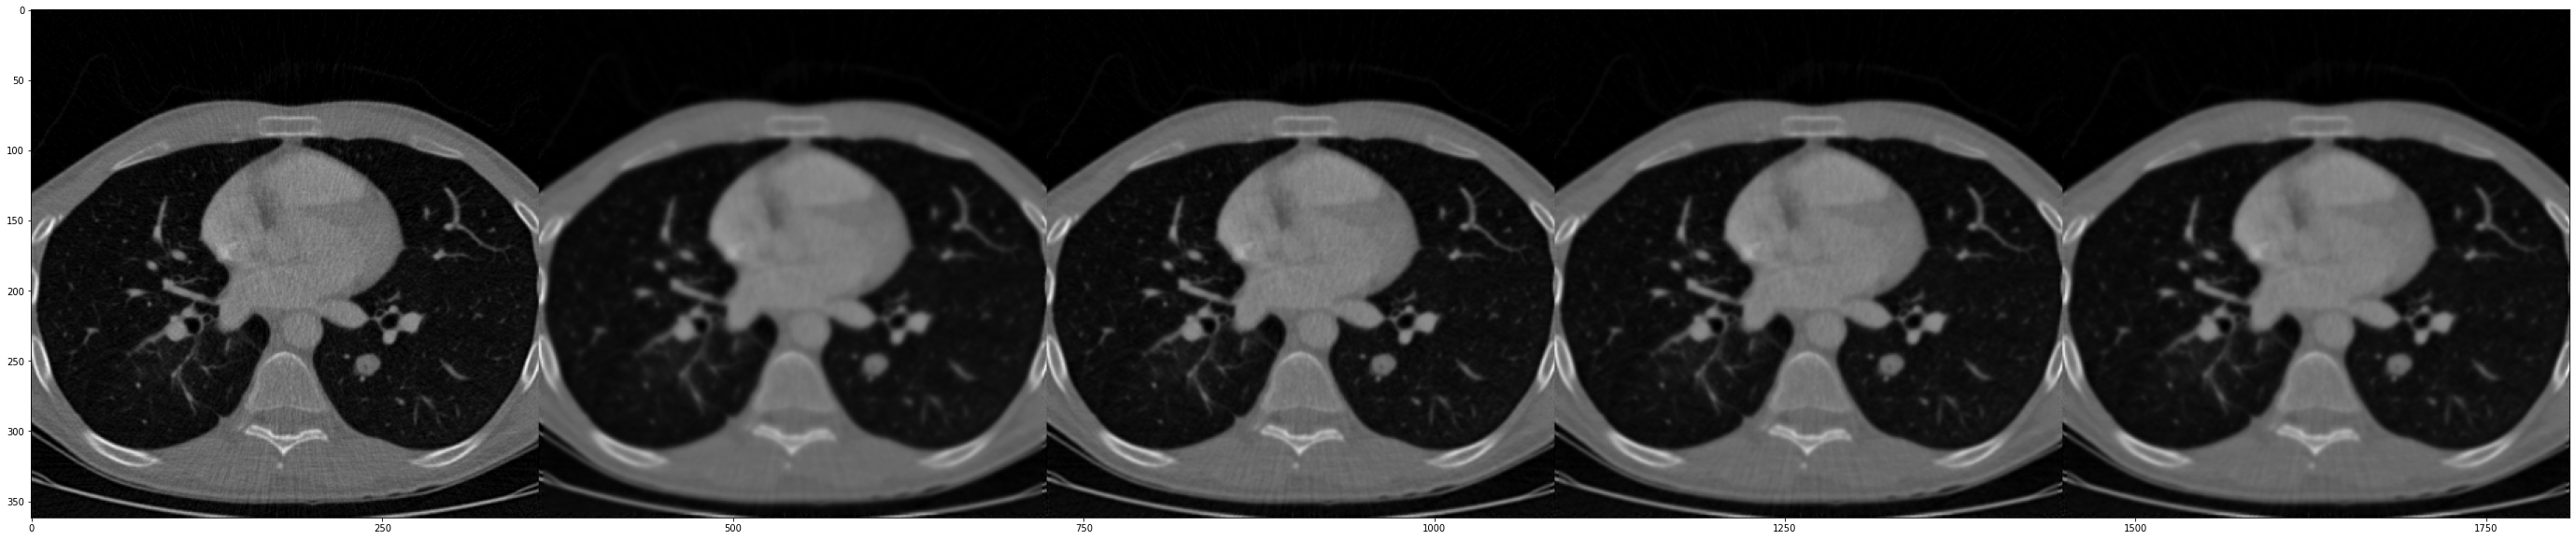

In [24]:
index = np.random.randint(0, 1000)
a = np.load('/media/yu-hao/WindowsData/DivalRecon/'+str(index)+'_img_quadratic1.npy')
b = np.load('/media/yu-hao/WindowsData/DivalRecon/'+str(index)+'_beta_quadratic1.npy')
print(index, b.flatten())
plt.figure(figsize=(50,10))
plt.imshow(np.concatenate(a).T, cmap='gray')


(array([  2.45310000e+04,   1.87500000e+03,   3.24100000e+04,
          6.42050000e+04,   4.19700000e+03,   1.69800000e+03,
          9.96000000e+02,   9.38000000e+02,   1.84000000e+02,
          1.00000000e+01]),
 array([  0.00000000e+00,   5.36080275e-05,   1.07216055e-04,
          1.60824083e-04,   2.14432110e-04,   2.68040138e-04,
          3.21648165e-04,   3.75256193e-04,   4.28864220e-04,
          4.82472248e-04,   5.36080275e-04]),
 <BarContainer object of 10 artists>)

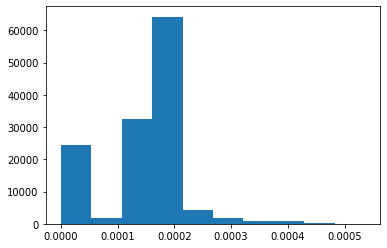

In [8]:
t1 = a
#plt.imshow(t1, cmap='gray')
plt.hist(a[3].flatten())

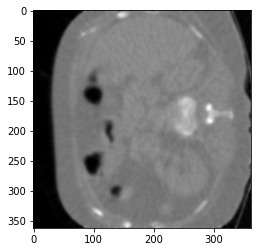

In [93]:
plt.imshow(vol_rec, cmap='gray')